# Exoplanet Classifer and Safronov Number
## *Which exoplanet type is most likely to scatter bodies like planets found in their planetary system?*
Emily Su, University of Toronto 

In this notebook, we will look at the different exoplanets on the NASA Exoplanet Archive as of June 10, 2023. We will first use the k-means clustering algorithm to classify them into different types. We will then calculate their Safronov numbers to measure their tendency to scatter bodies like planets out of their planetary system (McDonald & Veras, 2023; Safronov, 1972). 

We want to see the relationship between the type of exoplanet and its Safronov number and determine the likelihood of certain types of exoplanets scattering bodies found in their planetary system.

In [ ]:
# Libraries
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Exoplanets/exoplanets.csv')
data.head()

,loc_rowid,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,...,ra,decstr,dec,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,rowupdate,pl_pubdate,releasedate
0,1,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,...,185.178779,+17d47m35.71s,17.793252,93.1846,4.72307,2.282,4.44038,2014-05-14,Jan-08,2014-05-14
1,2,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,...,185.178779,+17d47m35.71s,17.793252,93.1846,4.72307,2.282,4.44038,2014-07-23,Aug-11,2014-07-23
2,3,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,...,229.274595,+71d49m26.19s,71.823943,125.3210,5.01300,1.939,4.56216,2018-04-25,Oct-09,2014-05-14
3,4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,...,229.274595,+71d49m26.19s,71.823943,125.3210,5.01300,1.939,4.56216,2018-04-25,Aug-11,2014-07-23
4,5,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,...,229.274595,+71d49m26.19s,71.823943,125.3210,5.01300,1.939,4.56216,2018-09-04,Mar-17,2018-09-06


# Cleaning and Filtering Data

In [6]:
# Filter out columns
data_filtered = data[["hostname", "discoverymethod", "sy_pnum", "pl_rade", "pl_orbper", "pl_orbsmax", "pl_bmasse", "sy_dist", "pl_eqt", "st_mass", "releasedate"]]

# # Filter out only exoplanets published by NASA Exoplanet Archive from 2023
# data_filtered = data_smaller[pd.DatetimeIndex(data_smaller["releasedate"]).year == 2023]

# Removing duplicate
data_filtered.drop_duplicates(subset=["hostname"], inplace=True)
data_filtered.head()

<ipython-input-6-ef7ae682388a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.drop_duplicates(subset=["hostname"], inplace=True)


,hostname,discoverymethod,sy_pnum,pl_rade,pl_orbper,pl_orbsmax,pl_bmasse,sy_dist,pl_eqt,st_mass,releasedate
0,11 Com,Radial Velocity,1,NaN,326.03,1.29,6165.6000,93.1846,NaN,2.70,2014-05-14
2,11 UMi,Radial Velocity,1,NaN,516.22,1.54,3337.0700,125.3210,NaN,1.80,2014-05-14
5,14 And,Radial Velocity,1,NaN,185.84,0.83,1525.5000,75.4392,NaN,2.20,2014-05-14
7,14 Her,Radial Velocity,2,NaN,1796.40,2.80,1506.4500,17.9323,NaN,0.90,2014-08-21
15,16 Cyg B,Radial Velocity,1,NaN,798.50,1.66,565.7374,21.1397,NaN,1.08,2018-09-06


# Classifying exoplanets 

We will classify exoplanets using their planetary mass (`pl_bmasse`) and their radius (`pl_rade`) into 4 clusters and each cluster would represent an exoplanet type. This will be done using k-means clustering.

In [7]:
# DataFrame with just host name, mass, and radius
mass_radius = data_filtered[["hostname", "pl_bmasse", "pl_rade"]]

# Filter out rows with no value in one of the columns
mass_radius.dropna()

,hostname,pl_bmasse,pl_rade
24,1RXS J160929.1-210524,2543.00000,18.647
35,2MASS J02192210-3925225,4417.83700,16.141
145,AU Mic,57.20940,4.203
174,BD+60 1417,4767.42610,14.684
195,CFHTWIR-Oph 98 A,2479.06157,20.849
...,...,...,...
34575,WTS-1,1274.44000,16.700
34576,WTS-2,403.64410,15.278
34581,Wendelstein-2,232.33373,12.993
34623,XO-3,3747.06000,13.641


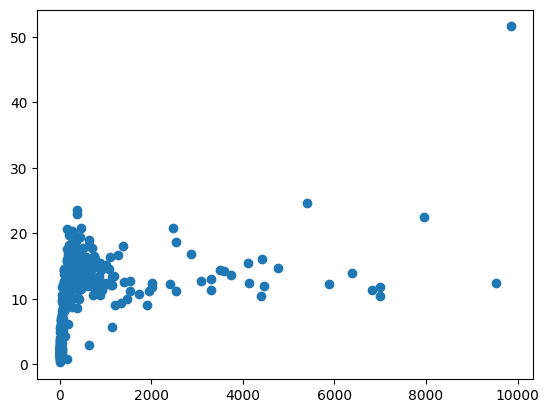

In [8]:
# Create temporary scatterplot (x-axis = mass and y-axis = radius)
plt.scatter(mass_radius["pl_bmasse"], mass_radius["pl_rade"])

In [9]:
# Creates 4 clusters
k_means = KMeans(n_clusters=4)

In [10]:
'''
This function takes in DataFrame for mass and radius and gets rid of rows 
containing "None" values.
and returns a DataFrame.
'''
def getCleanedDF(data):
 # Get rid of rows in each of all NA 
 data.dropna(inplace=True)

getCleanedDF(mass_radius)

new_mass_radius = mass_radius[["pl_bmasse", "pl_rade"]]
new_mass_radius.columns = ["Mass", "Radius"] # rename columns

clustering = k_means.fit_predict(new_mass_radius)
clustering

<ipython-input-10-bb59787e9c2e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 2, 3, 2, 2, 0, 2, 3, 0, 0, 3, 3, 2, 3, 0, 0, 0, 0, 3, 0, 3, 3,
       3, 2, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 2, 0, 0, 3, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 0, 0, 0, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,

In [23]:
# Add new column for cluster in the old and new mass_radius DataFrame
mass_radius["cluster"] = clustering
new_mass_radius["cluster"] = clustering

# Seperate each cluster into a DataFrame
cluster0 = new_mass_radius[new_mass_radius.cluster == 0]
cluster1 = new_mass_radius[new_mass_radius.cluster == 1]
cluster2 = new_mass_radius[new_mass_radius.cluster == 2]
cluster3 = new_mass_radius[new_mass_radius.cluster == 3]

print(cluster0.count())
print(cluster1.count())
print(cluster2.count())
print(cluster3.count())

Mass       66
Radius     66
cluster    66
dtype: int64
Mass       8
Radius     8
cluster    8
dtype: int64
Mass       18
Radius     18
cluster    18
dtype: int64
Mass       294
Radius     294
cluster    294
dtype: int64


<ipython-input-23-6a0e0fbfd1fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_radius["cluster"] = clustering
<ipython-input-23-6a0e0fbfd1fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_mass_radius["cluster"] = clustering


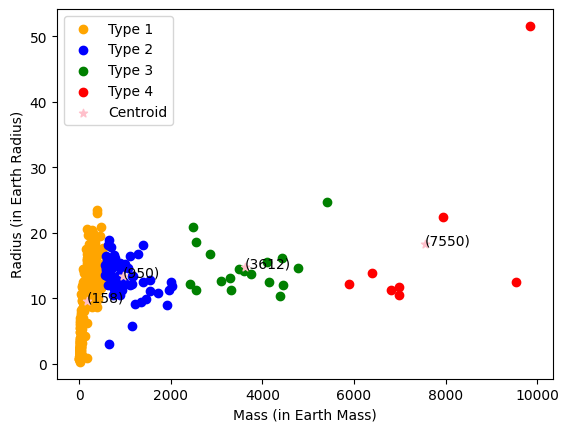

In [13]:
plt.scatter(cluster3.Mass, cluster3.Radius, color='orange', label = 'Type 1')
plt.scatter(cluster0.Mass, cluster0.Radius, color='blue', label = 'Type 2')
plt.scatter(cluster2.Mass, cluster2.Radius, color='green', label = 'Type 3')
plt.scatter(cluster1.Mass, cluster1.Radius, color='red', label = 'Type 4')
plt.scatter(k_means.cluster_centers_[:,0],k_means.cluster_centers_[:,1],color='pink',marker='*',label='Centroid')
plt.xlabel('Mass (in Earth Mass)')
plt.ylabel('Radius (in Earth Radius)')
plt.legend()

# Label the aaverage mass of each type 
for i, j in zip(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,1]):
   plt.text(i, j, '({})'.format(round(i), j))

We will use each of the centroids to approximate the exoplanet types. Looking at type 1, its centroid is about $158 M_{Earth}$, which means it is $9.436 \text{ x } 10^{26}kg$. This means on average in type 1, the exoplanets are Neptune-like ($1.024 \text{ x }10^{26} kg$). For type 2, its centroid is about $950 M_{Earth}$, which is $5.674 \text{ x } 10^{27}kg$ and for type 3, its centroid is around $3612 M_{Earth}$ or $2.1572 \text{ x } 10^{28}kg$. Finally for type 4, the centroid is $7550 M_{Earth}$ or $4.509 \text{ x } 10^{28}kg$. Type 2, type 3, and type 4 can be categorized as Gas Giants since they have a mass greater than Jupiter $1.898 \text{ x } 10^{27} kg$. As the centroid for type 2 is closer to Jupiter's mass, it can be categorized in a sub-category called "Jupiter-like".

Text(0.5, 1.0, 'Emily Su, University of Toronto')

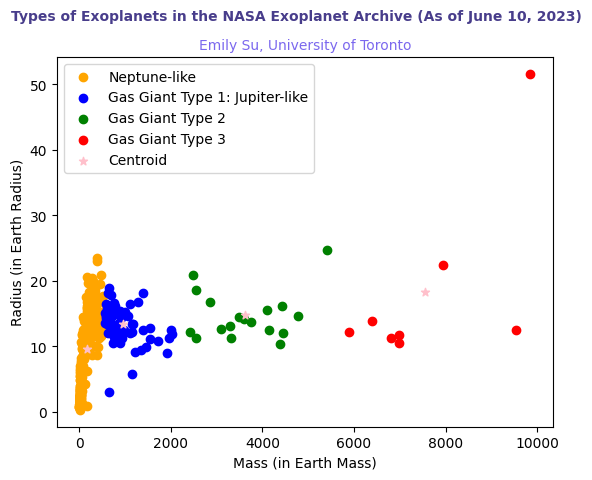

In [27]:
plt.scatter(cluster3.Mass, cluster3.Radius, color='orange', label = 'Neptune-like')
plt.scatter(cluster0.Mass, cluster0.Radius, color='blue', label = 'Gas Giant Type 1: Jupiter-like')
plt.scatter(cluster2.Mass, cluster2.Radius, color='green', label = 'Gas Giant Type 2')
plt.scatter(cluster1.Mass, cluster1.Radius, color='red', label = 'Gas Giant Type 3')
splot = plt.scatter(k_means.cluster_centers_[:,0],k_means.cluster_centers_[:,1],color='pink',marker='*',label='Centroid')
plt.xlabel('Mass (in Earth Mass)')
plt.ylabel('Radius (in Earth Radius)')
plt.legend()

plt.suptitle("Types of Exoplanets in the NASA Exoplanet Archive (As of June 10, 2023)",
          fontsize=10,
          fontweight="bold",
          color="darkslateblue")
plt.title("Emily Su, University of Toronto",
          fontsize=10,
          color="mediumslateblue")

# Calculating Average Safronov Number of Each Type of Exoplanet

We will first calculate the Safronov number of each exoplanet using the following formula (Safronov, 1972; McDonald & Veras, 2023): 
$$\theta = \frac{a}{R}\frac{M_p}{M_{s}}$$

**Notations**:\
a = the orbit semi-major axis (m)\
R = radius of the planet (m)\
$M_p$ = mass of the planet (kg)\
$M_s$ = mass of the star (kg)


In [28]:
# Obtain DataFrame with only host name, mass, radius, stellar mass, and orbit semi-major axis in AU 
mass_radius_semimajor = data_filtered[["hostname", "pl_bmasse", "pl_rade", "st_mass", "pl_orbsmax"]]
# Combine above dataframe with dataframe with clusters
combined_df = pd.merge(mass_radius_semimajor, mass_radius, on="hostname")
getCleanedDF(combined_df) # Remove rows with missing information
combined_df.head()

,hostname,pl_bmasse_x,pl_rade_x,st_mass,pl_orbsmax,pl_bmasse_y,pl_rade_y,cluster
0,1RXS J160929.1-210524,2543.00000,18.647,0.85,330.000,2543.00000,18.647,2
1,2MASS J02192210-3925225,4417.83700,16.141,0.11,156.000,4417.83700,16.141,2
2,AU Mic,57.20940,4.203,0.50,0.066,57.20940,4.203,3
3,BD+60 1417,4767.42610,14.684,1.00,1662.000,4767.42610,14.684,2
4,CFHTWIR-Oph 98 A,2479.06157,20.849,0.01,200.000,2479.06157,20.849,2


## Convert units

In [29]:
combined_df_copy = combined_df.copy() # Make a deep copy 

# orbit semi-major axis - from AU to m
combined_df_copy["Semi-major axis (m)"] = combined_df_copy.pl_orbsmax * (1.496 * (10**11))

# radius - from earth radius to m
combined_df_copy["Planet Radius (m)"] = combined_df_copy.pl_rade_x * (6.378 * (10**6))

# mass of planet - from earth mass to kg 
combined_df_copy["Planet Mass (kg)"] = combined_df_copy.pl_bmasse_x * (5.972 * (10**24))

# mass of star - from solar mass to kg 
combined_df_copy["Solar Mass (kg)"] = combined_df_copy.st_mass * (1.989*(10**30))

converted_units_df = combined_df_copy[["hostname", "Semi-major axis (m)", "Planet Radius (m)", "Planet Mass (kg)", "Solar Mass (kg)", "cluster"]]
converted_units_df.head()

,hostname,Semi-major axis (m),Planet Radius (m),Planet Mass (kg),Solar Mass (kg),cluster
0,1RXS J160929.1-210524,4.936800e+13,118930566.0,1.518680e+28,1.690650e+30,2
1,2MASS J02192210-3925225,2.333760e+13,102947298.0,2.638332e+28,2.187900e+29,2
2,AU Mic,9.873600e+09,26806734.0,3.416545e+26,9.945000e+29,3
3,BD+60 1417,2.486352e+14,93654552.0,2.847107e+28,1.989000e+30,2
4,CFHTWIR-Oph 98 A,2.992000e+13,132974922.0,1.480496e+28,1.989000e+28,2


## Calculate Safronov Number

In [30]:
converted_units_df['Safronov Number'] = (converted_units_df.iloc[:,1] / converted_units_df.iloc[:,2]) * (converted_units_df.iloc[:,3] / converted_units_df.iloc[:,4])
converted_units_df.head()

<ipython-input-30-22549384f454>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  converted_units_df['Safronov Number'] = (converted_units_df.iloc[:,1] / converted_units_df.iloc[:,2]) * (converted_units_df.iloc[:,3] / converted_units_df.iloc[:,4])


,hostname,Semi-major axis (m),Planet Radius (m),Planet Mass (kg),Solar Mass (kg),cluster,Safronov Number
0,1RXS J160929.1-210524,4.936800e+13,118930566.0,1.518680e+28,1.690650e+30,2,3728.760575
1,2MASS J02192210-3925225,2.333760e+13,102947298.0,2.638332e+28,2.187900e+29,2,27336.521970
2,AU Mic,9.873600e+09,26806734.0,3.416545e+26,9.945000e+29,3,0.126536
3,BD+60 1417,2.486352e+14,93654552.0,2.847107e+28,1.989000e+30,2,38001.672243
4,CFHTWIR-Oph 98 A,2.992000e+13,132974922.0,1.480496e+28,1.989000e+28,2,167480.471133


In [31]:
# Seperate each cluster into a DataFrame
cluster0_df = converted_units_df[converted_units_df.cluster == 0]
cluster1_df = converted_units_df[converted_units_df.cluster == 1]
cluster2_df = converted_units_df[converted_units_df.cluster == 2]
cluster3_df = converted_units_df[converted_units_df.cluster == 3]

### Calculate average Safronov number for each exoplanet type we have defined previously

In [32]:
# Gas Giant Type 1: Jupiter-like  
cluster0_avg = (cluster0_df['Safronov Number'].sum() / cluster0_df['Safronov Number'].count()) 
print(cluster0_avg)
# Gas Giant Type 3
cluster1_avg = (cluster1_df['Safronov Number'].sum() / cluster1_df['Safronov Number'].count())
print(cluster1_avg)
# Gas Giant Type 2
cluster2_avg = (cluster2_df['Safronov Number'].sum() / cluster2_df['Safronov Number'].count())
print(cluster2_avg)
# Neptune-like
cluster3_avg = (cluster3_df['Safronov Number'].sum() / cluster3_df['Safronov Number'].count())
print(cluster3_avg)

3897.8618227107177
2298.11787563087
21584.033630933092
0.1133947573497651


The exoplanet type with the highest $\theta$ value here is Gas Giant Type 2. This indicates that heavier exoplanets are more capable of scattering bodies in their planetary system and potentially eject them out of the plantery system. 



# References

Catriona, H. M., & Veras, D. (2023). Binary asteroid scattering around white dwarfs. *Monthly Notices of the Royal Astronomical Society*, *520*(3), 4009–4022, https://doi.org/10.1093/mnras/stad382

Safronov, V. S. (1972). *Evolution of the protoplanetary cloud and formation of the earth and the
planets.* Keter Publishing House.
  